# Machine Learning summative.
### Candidate number: 1047951

# TABLE OF CONTENTS:

## 1. PCA Practical
#### 1.1. Proportion of variance explained
#### 1.2. Visualizing data in two-dimensional space
#### 1.3. Visualizing data with T-SNE
#### 1.4. Visualizing images by explained variance
#### 1.5. Plotting eigenvectors
## 2. PCA theoretical - Simulating the exercise
#### 2.1. Generating variables
#### 2.2. Extracting uncorrelated variables
#### 2.3. Simulating PCA
#### 2.4. Computing Lasso coefficients and PCA output
#### 2.5. Writing out PCA component equations
## 3. Support vector machines (Practical)
#### 3.1. Linear kernel
#### 3.2. Tuning the linear kernel
#### 3.3. Radial basis function kernel
#### 3.4. Polynomial kernel
#### 3.5. Sigmoid kernel
## 4. Neural Networks implementation
## 5. Neural Networks practice

In [573]:
# General imports
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import random
from sklearn.svm import SVC
import seaborn as sns

# Stats /Math imports
from scipy.linalg import eigh, cholesky
from scipy.stats import norm
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

# 1. PCA Practical

In [6]:
def load_data(normalize=True):
    """
    Loads the train and test data
    """
    
    # Set parmas
    no_digits = 255
    
    # Load the data
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(60000,784)
    x_test = x_test.reshape(10000,784)

    if normalize:
        x_train = x_train / no_digits
        x_test = x_test / no_digits
        

    # Get full x,y datasets
    x = np.concatenate([x_train, x_test])
    y = np.concatenate([y_train, y_test])
    
    return x, y, x_train, y_train, x_test, y_test


def get_sample(x, y, sample_size):
    """
    Gets a sample form the data and returns the same
    indices for both x and y.
    """
    
    # Assert the same number of Ys
    assert x.shape[0] == y.shape[0], 'Dimensions are not equal'

    # Minimize the input dims
    indices = random.sample(range(x.shape[0]), sample_size)
    x = x[indices]
    y = y[indices]

    return x, y

In [684]:
x, y, x_train, y_train, x_test, y_test = load_data()
#x, y = get_sample(x,y,5000)

## 1.1 Proportion of variance explained

In [685]:
pca = PCA()
pca.fit(x)

PCA()

In [724]:
def get_explained_variance_pca(pca):
    """
    Gets the PCA plot explanation
    """
    # Get parameters to be used
    exp_var = pca.explained_variance_ratio_
    exp_var = np.array([(x+1,y) for x,y in enumerate(exp_var)])
    n_components = exp_var.shape[0]
    
    fig, axs = plt.subplots(1,3,figsize=(24,6))

    axs[0].plot(np.cumsum(pca.explained_variance_ratio_))
    axs[0].set_xlabel('number of components')
    axs[0].set_ylabel('cumulative explained variance');
    axs[0].set_title('Proportion of variance explained by each component');
    axs[0].set_xlim(-50,784)
    axs[0].grid()
    
    axs[1].plot(exp_var[:n_components,0], exp_var[:n_components,1])
    axs[1].set_title("Proportion of variance explained by each component (linear scale)")
    axs[1].set_xlabel("Principal component")
    axs[1].set_ylabel("Explained variance ratio")
    axs[1].set_xlim(-50,784)
    axs[1].grid()
    
    axs[2].semilogy(exp_var[:n_components,0], exp_var[:n_components,1])
    axs[2].set_title("Proportion of variance explained by each component (log scale)")
    axs[2].set_xlabel("Principal component")
    axs[2].set_ylabel("Explained variance ratio")
    axs[2].set_ylim(1e-10, 1)
    axs[2].set_xlim(-50,784)
    axs[2].grid();

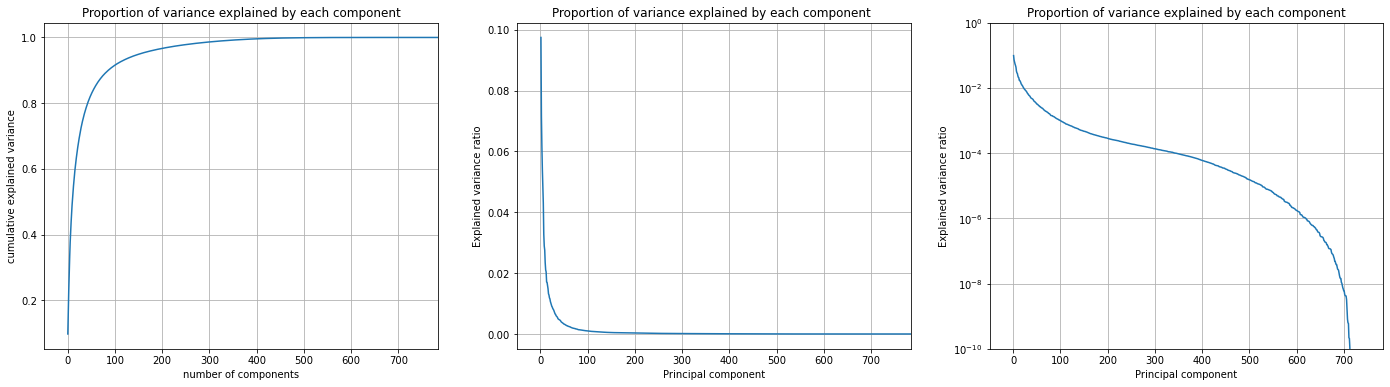

In [725]:
get_explained_variance_pca(pca)

All three plots indicate the same idea from different angles: after we take the first 50 - 100 eigenvectors, the variance explained by each additional eigenvector decrease substantially. After taking the first 100 components, the cumulative variance is about is 90 - 95%. The log scale shows that the 200th principal component explains only about $10^{-4}$ variance per new component.

## 1.2. Visualizing data in two-dimensional space

In [688]:
x_transf = pd.DataFrame(pca.fit_transform(x))
x_transf.columns = [str(x) for x in x_transf.columns]

In [691]:
def plot_top_two_components(x_transf):
    """
    Plot the top two components
    """
    fig, ax = plt.subplots(figsize=(12,7))
    

    sns.scatterplot(x='0', y='1', hue=y,palette=sns.color_palette('hls', 10),
                    data=x_transf, legend='full', ax=ax, alpha=0.3)
    
    ax.set_title('PCA visualized by the first two principal components')
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")

    
    plt.tight_layout()

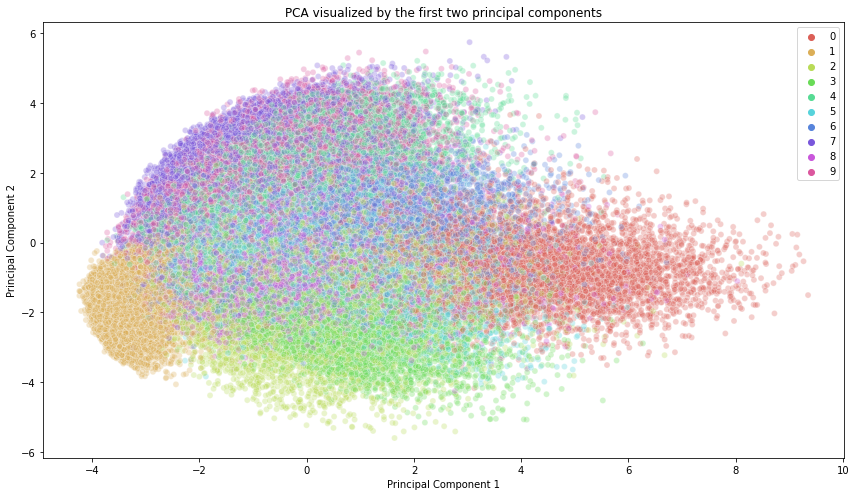

In [692]:
plot_top_two_components(x_transf)

It can be seen that taking just the first two principle components provides us with a picture that can cluster similar digits together. For instance, many of the digits "1" are clustered at the lower left corner of the plot. Nevertheless, there is substantial overlap between the digits. In order to visualize the data better, I use t-distributed stochastic neighbor embeddings.

## 1.3. Visualizing the data with a t-distributed stochastic neighbor embedding (T-SNE)

In [714]:
# Get TSNEs
x_transf_sample, y_sample = get_sample(np.array(x_transf), y, 10_000)
tsne = TSNE(n_components = 2, random_state=0, n_jobs=-1, perplexity = 50)
tsne_res = tsne.fit_transform(x_transf_sample)

In [715]:
def get_tsne_plot(tsne_res, y):
    """
    Plot the t-distributed stochastic neighbor embeddings.
    """
    fig, ax = plt.subplots(figsize=(13,6))
    sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y, palette = sns.hls_palette(10), legend = 'full', alpha = 0.5)
    ax.set_title('T-SNE distribution of the transformed MNIST Dataset');

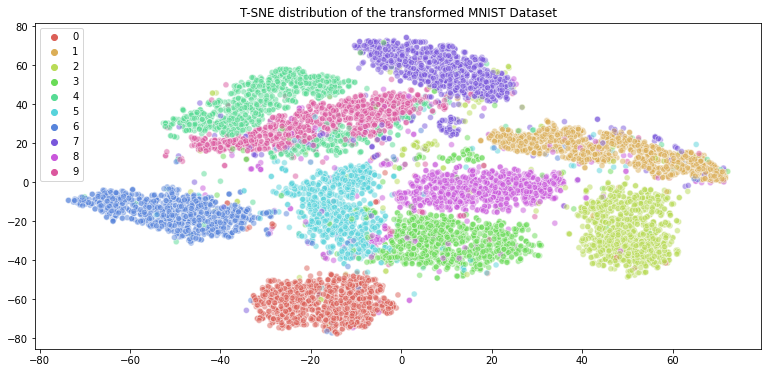

In [716]:
get_tsne_plot(tsne_res, y_sample)

T-SNE maps a high dimensional space into a lower dimensional space, in this case, two-dimensional, in a way that it preserves the neighborhood distance between points. The T-SNE plot shows that there is substantial overlap between the numbers 4 and 9, as well as the digits 5 and 3 once plotted in two-dimensional space and colored by the digits. However, the limitations of a T-SNE plot should be acknowledged. The t-SNE is non-convex, thus the data portrayed might have landed in a local minimum. Second, the transformations being done are non-linear and local, i.e. they can be different on different regions of the data. 

The depiction was made after running the algorithm through multiple values of perplexity to determine the best balance between local and global aspects of the data. A value of 50 was chosen, but other values might reveal different stories. Furthermore, a sample of 10,000 random digits is represented to ensure readability of the data.

## 1.4. Visualizing images by the explained variance

In [717]:
def fit_pca(var_expl, data, img_nr):
    """
    Fit a PCA model and returns the transformed images
    and number of components of the PCA
    """
    
    pca = PCA(var_expl)
    pca.fit(data)

    # Get photo in reduced space
    data_reduced = pca.fit_transform(data)
    new_imgs = pca.inverse_transform(data_reduced)
    n_components = pca.n_components_

    # Select an image to plot
    img = new_imgs[img_nr]
    
    return img, n_components


def get_var_subplots(data, rows=2, cols=4, variance_explained=[0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99], img_nr=0):
    """
    Get subplots of the variance explained by different images.
    """
    
    fig, axs = plt.subplots(rows,cols, figsize=(16,7))
    
    fig.suptitle('Images by variance explained', fontsize=16)
    
    # Get iterator variables
    i = 0; j = 0
    
    for var_expl in variance_explained:
        
        img, n_components = fit_pca(var_expl, data, img_nr=img_nr)
        
        # Plot
        axs[i,j].imshow(img.reshape(28,28), cmap=plt.cm.gray, interpolation='nearest')
        axs[i,j].set_title(f'Variance: {int(var_expl*100)}%, components: {n_components}')

        # Plot the final separately
        axs[rows-1,cols-1].imshow(data[img_nr].reshape(28,28), cmap = plt.cm.gray)
        axs[rows-1,cols-1].set_title(f'Original image')

        # Re-set iterators
        j+=1 
        if j == cols: i = 1; j = 0
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

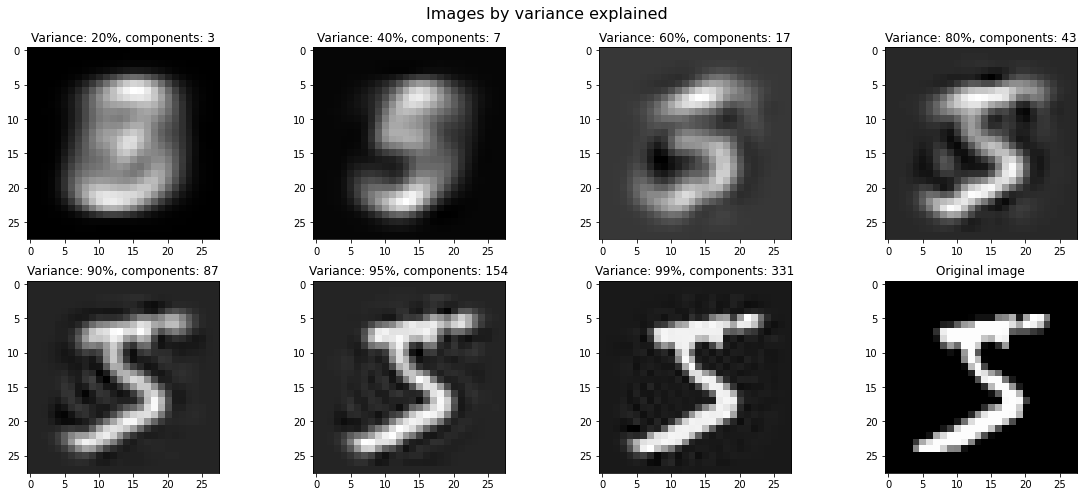

In [718]:
get_var_subplots(x)

We can see that even 7 components provide enough information for us to infer that the number being depicted in a two. The image improves visually significantly until 85 components (90% of variance explained). Afterward, each additional component adds very few information. 99% of the variance is explained by fewer than half of the components.

## 1.5. Plotting eigenvectors

In [719]:
def plot_eigenvectors(first_eigens, rows=3, cols=6, plots=18):
    """
    Plotting eigenvectors of the images
    """
    fig, axs = plt.subplots(rows,cols, figsize=(20,8))
    fig.suptitle(f"Visualization of the eigenvectors after PCA", fontsize=16)
    
    i = 0
    j = 0
    
    # Choose plot type
    if first_eigens: plot_range = range(plots)
    else: plot_range = range(19,720,40)
        
    for k in plot_range:
        axs[i,j].imshow(pca.components_[k].reshape(28,28), cmap = plt.cm.gray)
        axs[i,j].set_title(f"Eigenvector {k+1}")
        if i != (rows-1):
            axs[i,j].set_xticklabels("")

        # Re-set iterators
        j+=1 
        if j == cols: i += 1; j = 0
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

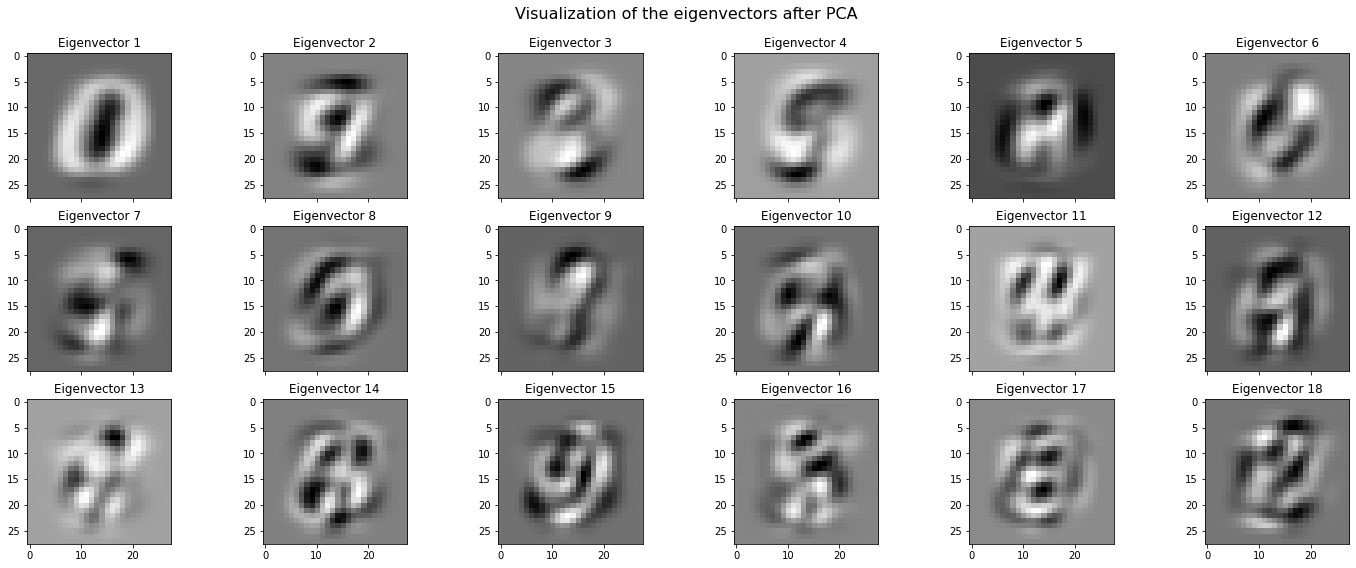

In [720]:
plot_eigenvectors(first_eigens=True)

The subplots depict the 18 eigenvectors that were found by performing principal component analysis. Note that the first eigenvectors showcase rather clear "directions" on the plot. For instance, the first eigenvector seems to be focused on the direction of a straight line, the third eigenvector seems to replicate the form of a "3" in the eigenspace.  Eigenvectors 18 already showcase specific, more involved directions that are not that easily interpreted. 

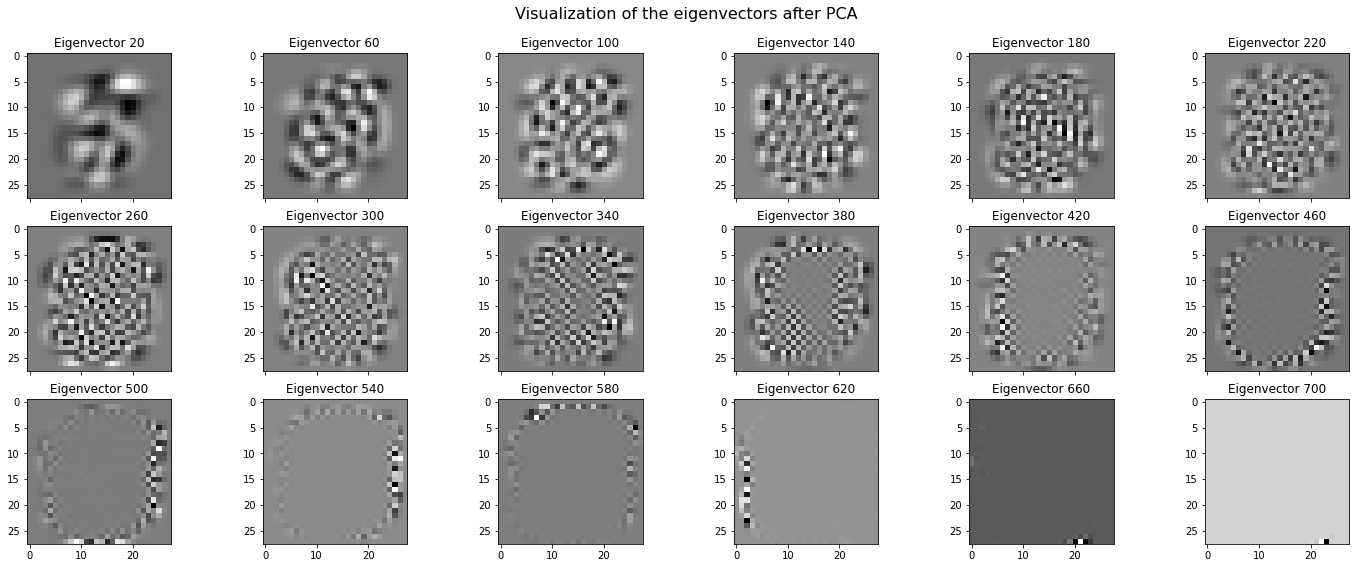

In [721]:
plot_eigenvectors(first_eigens=False)

Notice that the next eigenvectors explain less specific directions. The 60th eigenvector tries to maximize the variance in the feature subspace within the main part where the digits are written. However, the last eigenvectors start explaining the variance around the plot that offers marginal improvements to the model. 

# 2. PCA Theoretical - Simulating the exercise

In this part, I re-create the conditions provided in the exercise to simulate the MSE of the Lasso and PCA regressions. I run 10,000 simulations on newly created data that satisfy the conditions of having variance 1 and resulting in the provided PCA PVE plot.

## 2.1. Generating normally distributed variables that are correlated with variance 1 each

In this section, I generate the correlated variables and check to make sure they satisfy the conditions provided.

In [27]:
n = 500 # sample size
n_dist = 20  # number of predictors
n_sim = 10000

In [28]:
def generate_cov(dim, corr=0.0):
    """
    Generate a covariance matrix
    """
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr 
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)


def get_data_x(scalar=15, corr=0.2):
    """
    Creates 20 correlated predictors, multiplies the by a scalar
    and a random variable, and then scales them to have a mean
    of zero and variance of one.
    """
    
    # generate random normal distribution
    temp = []
    for i in range(n_dist):
        temp.append(np.reshape(np.random.normal(0,1,n),(n,-1)))
        
    # Compute
    all_norm = np.concatenate(temp,axis=1)

    # 20 correlated predictors
    cov = generate_cov(n_dist, corr=corr)
    C = np.linalg.cholesky(cov)
    X = np.transpose(0 + np.dot(C,np.transpose(all_norm) ))

    for i in range(20):
        X[i] = X[i] * np.random.rand() * scalar

    for i in range(20):
        X[:,i] = preprocessing.scale(X[:,i])
    
    return X


def fit_PCA(X):
    """
    Fit a PCA and return just the explained variance ratio
    """
    pca = PCA()
    pca.fit(X)

    exp_var = pca.explained_variance_ratio_
    n_components = exp_var.shape[0]
    
    return exp_var


def simulate_PCA_PVE(X, n_sim=1000):
    """Simulate the PCA for the provided data n_sim times"""
    comp = []
    for i in range(n_sim):
        X = get_data_x()
        exp_var = fit_PCA(X)
        comp.append(exp_var)
        
    return comp

In [29]:
X = get_data_x()
comp = simulate_PCA_PVE(X, n_sim=n_sim)

In [536]:
def plot_PVE_PCA(comp, n_sim=n_sim):
    """
    Plot the graph of PVE and PCA after the given amount of simulations
    """
    exp_var_agg = np.array(comp).mean(axis=0)
    exp_var_agg = np.array([(int(x+1),y) for x,y in enumerate(exp_var_agg)])

    fig, axs = plt.subplots(figsize=(8,6))
    axs.scatter(exp_var_agg[:n_dist,0], exp_var_agg[:n_dist,1])
    axs.set_title(f"Average PVE of PCA after {n_sim} simulations ")
    axs.set_xlabel("Principal component")
    axs.set_ylabel("Proportion of variance explained")
    
    fig.savefig('PCA_results.png')

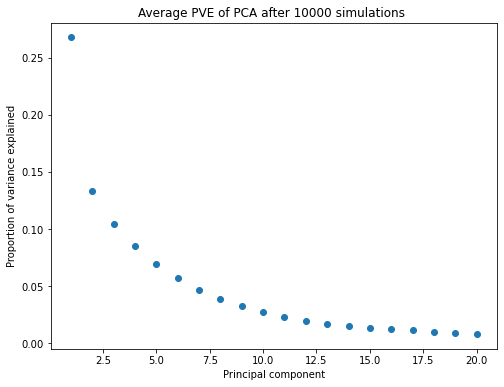

In [537]:
plot_PVE_PCA(comp)

In [32]:
print("Variance of the variables: {}".format(np.var(X, axis=0)))
print("Mean of the variables: {}".format(np.mean(X, axis=0).round(1)))

Variance of the variables: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean of the variables: [-0.  0. -0. -0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0.
  0. -0.]


## 2.2. Extracting two uncorrelated variables and simulating a response

In [33]:
def get_two_uncorrelated_vars(new_pred=2):
    """
    Extract two uncorrelated predictors with anyone else
    """
    # 2 uncorrelated predictors
    new_cov = generate_cov(new_pred, corr=0.0)
    new_C = np.linalg.cholesky(new_cov)
   
    temp = []
    for i in range(new_pred):
        temp.append(np.reshape(np.random.normal(0, 1,n),(n,-1)))
    
    new_norm = np.concatenate(temp,axis=1)

    new_X = np.transpose(0 + np.dot(new_C,np.transpose(new_norm)))
    
    np.round(np.corrcoef(new_X,rowvar=False),2)
    
    return new_X


def get_full_dataframe(X):
    """
    Get the full dataframe that contatenates the new predictors with the old ones
    
    """
    
    # Convert Y to dataframe
    x_df = pd.DataFrame(X)
    x_df.columns = range(1,21)
    new_X = get_two_uncorrelated_vars()
    
    # Convert to dataframe
    df_new_x = pd.DataFrame(new_X)
    df_new_x.columns = [21,22]
    
    # Concatenate the two dataframes
    full_df = pd.concat([x_df, df_new_x], axis=1)
    full_df.columns = ['X' + str(x) for x in full_df.columns]
    
    return full_df


def get_response(full_df):
    """
    Get response
    """
    y_resp = 0.5 + 0.1*full_df['X9'] +0.05*full_df['X13'] + 1.7*full_df['X21'] + 2.2 * full_df['X22'] * 2.2 + 0.1* np.random.randn()
    
    return y_resp

In [540]:
def plot_correlation_df(full_df):
    """
    Plots a correlation plot between the predictors.
    """
    # Calculate correlations
    corr = full_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Plot the correlations
    fig, ax = plt.subplots(figsize=(20,10))
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title("Pearson's correlation of all the simulated variables for a single simulation", fontsize=15)
    ax.set_xlabel("Variable name")
    ax.set_ylabel("Variable name")
    fig.savefig('corr_plot.png');

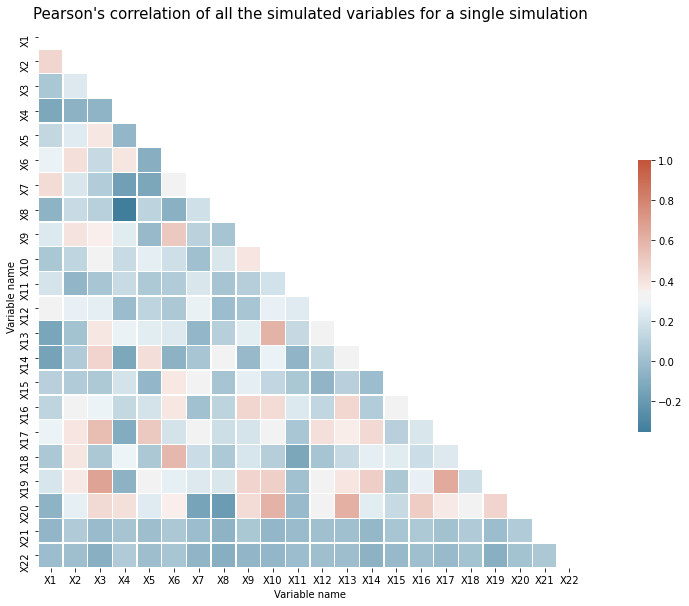

In [35]:
X = get_data_x()
full_df = get_full_dataframe(X)
plot_correlation_df(full_df)

Notice that the last two variables, $X_{21}$ and $X_{22}$ are not correlated with any of the other variables and do not co-vary.

## 2.3. Simulate PCA and Lasso Regressions
This part simulates the PCA and Lasso regression responses to the given equation.

In [36]:
def get_pca_reg(full_df, y_resp, n_components=2):
    """Gets PCA results"""
    pca = PCA(n_components = n_components)
    pca.fit(full_df)

    X_transform = pca.transform(full_df)

    model = LinearRegression().fit(X_transform, y_resp)
    
    pred = model.predict(X_transform)
    
    mse = mean_squared_error(y_resp, pred)
    
    return mse, pca.components_


def get_lasso_mse(full_df, y_resp, alpha=0.8, alpha_decrement=0.01, coef_to_keep=2):
    """
    Get the MSE for the Lasso regression. Start with a given alpha value and decrement
    it until only two predictors are remaining.
    """
    # Do initial lasso
    lasso = Lasso(alpha=alpha)
    lasso.fit(full_df, y_resp)
    
    # Get coefficients
    all_coef = len(lasso.coef_)
    coef_to_remove = all_coef-coef_to_keep
    mse = mean_squared_error(lasso.predict(full_df), y_resp)

    # Loop until the alpha value is small enough to give back only two coefficients
    while np.sum(lasso.coef_ == 0) != coef_to_remove:
        
        if np.sum(lasso.coef_ == 0) < 20:
            raise ValueError("3 values are found")
            
        alpha -= alpha_decrement
        lasso = Lasso(alpha=alpha)
        lasso.fit(full_df, y_resp)
        mse = mean_squared_error(lasso.predict(full_df), y_resp)
    
    return mse, lasso.coef_

In [561]:
def get_simulation_results():
    """
    Get simulation results and plot them
    """
    
    # Extract the data
    X = get_data_x()
    full_df = get_full_dataframe(X)
    
    # Simulate a response
    y_resp = get_response(full_df)
    
    # Calculate the results
    mse_pca, pca_comp = get_pca_reg(full_df, y_resp)
    mse_lasso, lasso_coef = get_lasso_mse(full_df, y_resp)

    return mse_pca, pca_comp, mse_lasso, lasso_coef

In [38]:
# Running simulations
n_sim = 10_000

mse_pca_list = []
pca_comp_list = []
mse_lasso_list = []
lasso_coef_list = []
for _ in range(n_sim):
    
    mse_pca, pca_comp, mse_lasso, lasso_coef = get_simulation_results()
    
    # Append results
    mse_pca_list.append(mse_pca)
    pca_comp_list.append(pca_comp)
    mse_lasso_list.append(mse_lasso)
    lasso_coef_list.append(lasso_coef)

In [39]:
def plot_mse_separately(mse_pca_list, mse_lasso_list):
    """
    Plot the MSEs of Lasso and PCA separately
    """
    
    fig, axs = plt.subplots(1, 2, figsize=(20,6))

    sns.distplot(np.array(mse_lasso_list), ax=axs[0], color = 'r')
    axs[0].set_title("MSE of the Lasso regression with 2 non-zero coefficients")
    axs[0].set_xlabel("MSE")
    axs[0].set_ylabel("Probability density")
    
    sns.distplot(np.array(mse_pca_list), ax=axs[1])
    axs[1].set_title("MSE of PCR with 2 components")
    axs[1].set_xlabel("MSE")
    axs[1].set_ylabel("Probability density")


In [542]:
def plot_mse_together(mse_pca_list, mse_lasso_list):
    """
    Plot the MSEs of PCA and Lasso together
    """
    fig, ax = plt.subplots(figsize=(10,5))
    sns.distplot(np.array(mse_lasso_list), ax=ax, label = 'Lasso', color = 'red')
    sns.distplot(np.array(mse_pca_list), ax=ax, label = 'PCR')

    ax.set_title(f"MSE of Lasso and PCR visualized together, {n_sim} simulation results")
    ax.set_xlabel("Mean squared error")
    ax.set_ylabel("Probability density")
    ax.legend()
    fig.savefig('mse_together.png');

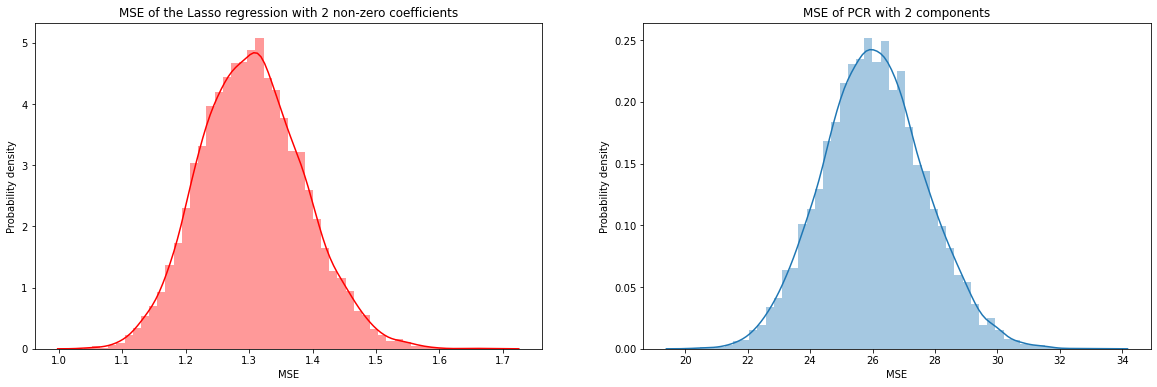

In [41]:
plot_mse_separately(mse_pca_list, mse_lasso_list)

There is variation in both of the mean squared errors, yet it can be seen that Lasso is significantly more concentrated toward one number. The graph below pictures them together, in one single graph

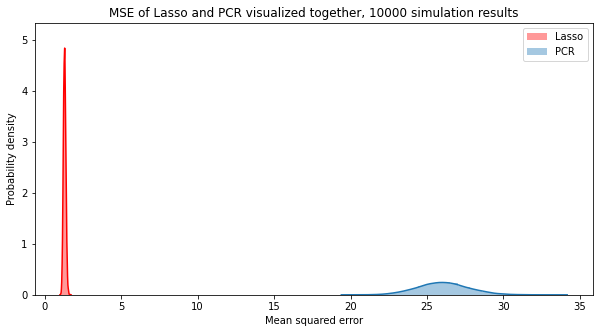

In [543]:
plot_mse_together(mse_pca_list, mse_lasso_list)

## 2.4. Comparing Lasso coefficients and PCA output

This subsection looks into the generated coefficients of the Lasso and PCA regressions

In [43]:
def change_cols(df):
    """Change the column names"""
    df.columns = ['X' + str(x)  for x in range(1,len(df.columns) +1)]
    return df

In [44]:
lasso_coef_df = pd.DataFrame(np.array(lasso_coef_list))
lasso_coef_df = change_cols(lasso_coef_df)

In [546]:
def get_variable_distribution(df, title, sharex=False):
    """
    Get variable distributions for the dataframe, visualizing the probability density
    
    """
    rows = 4
    cols = 6
    
    fig, axs = plt.subplots(rows, cols, figsize=(15,10), sharex=sharex)

    i = 0; j = 0
    for col in df.columns:
        
        # Check to see if there is any variation
        if df[col].sum() != 0:
            # Color code the two Xs differently
            if col in ['X21', 'X22']:
                sns.distplot(df[col], ax = axs[i,j], color = 'red')
            else: sns.distplot(df[col], ax = axs[i,j])
        else: 
            axs[i,j].set_xlabel(col)
            
        # Set y label only for the outer axis
        if j == 0:
            axs[i,j].set_ylabel('Probability density')

        # Re-set iterators
        j+=1 
        if j == cols: i += 1; j = 0

    # Remove axes that are not used for the variable depiction
    fig.delaxes(axs[3,4])
    fig.delaxes(axs[3,5])
    
    fig.suptitle(title, fontsize = 15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    fig.savefig(f'var_dist_{title}.png')

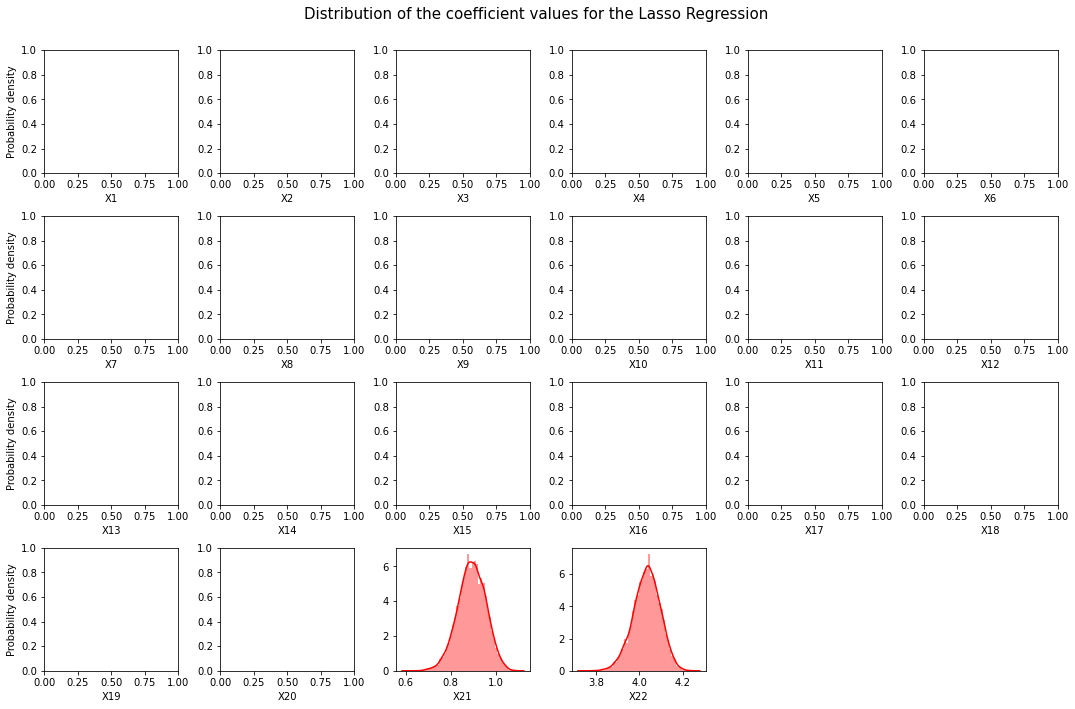

In [545]:
get_variable_distribution(lasso_coef_df, "Distribution of the coefficient values for the Lasso Regression")

This graph depicts that the only parameters that the Lasso regression considers in the given setting are the two last variables that are uncorrelated with all the other ones. 

In [47]:
first_comp_df = pd.DataFrame(np.array(pca_comp_list)[:,0,:])
second_comp_df = pd.DataFrame(np.array(pca_comp_list)[:,1,:])

first_comp_df = change_cols(first_comp_df)
second_comp_df = change_cols(second_comp_df)


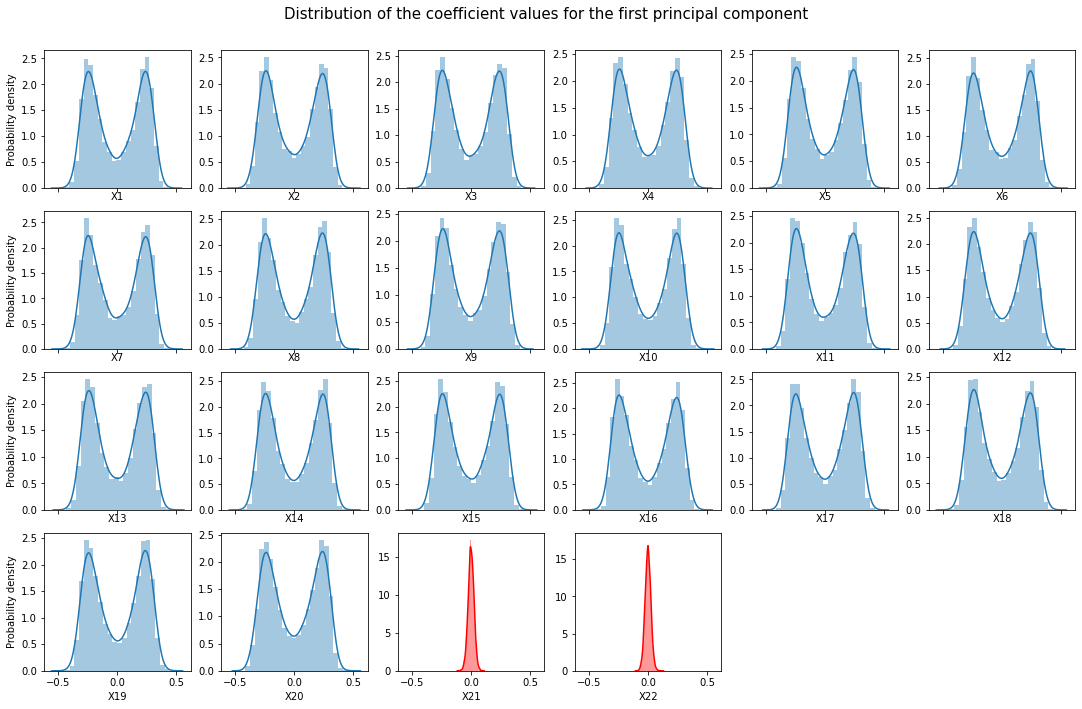

In [547]:
get_variable_distribution(first_comp_df, "Distribution of the coefficient values for the first principal component", sharex=True)

We can see that the first PCA has a bimodal distribution for all variables except for $X_{21}$ and $X_{22}$. This means that the variables were important for the first component in many of the cases, contributing either positively or negatively. However, The last two uncorrelated terms were consistently zeros with only slight variation around the zero. This showcases that the two variables have little effect on the PCA result, as they are not correlated with any of the other variables.

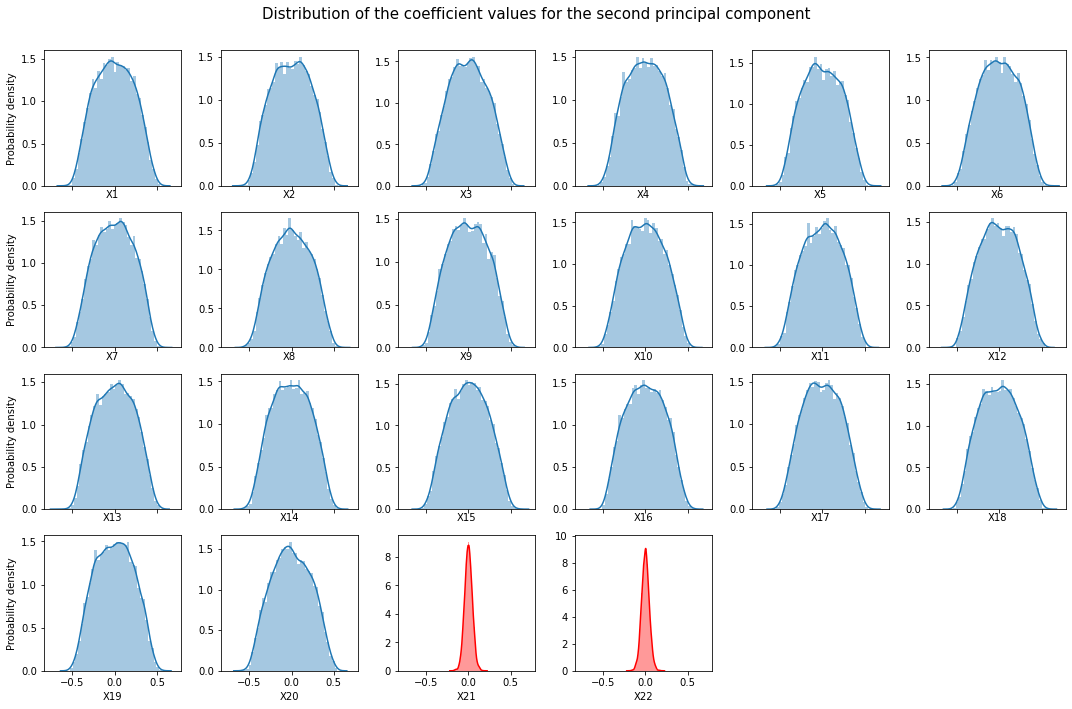

In [548]:
get_variable_distribution(second_comp_df, "Distribution of the coefficient values for the second principal component", sharex=True)

The second principal component has an already smaller effect with more $X$s centered around the mean. This should be expected, as the second eigenvector already explains less variation than before. Note, however, that the distribution of the last two uncorrelated $X$s has not changed- it is still centered around the mean.

## 2.5. Writing out PCA component equation
Below, I average all the component results and look at what, on average, constituted the first and second components. Note that the coefficients for the first 20 $X$s should be roughly the same, since they are generated at random, but they should be consistently higher than $X_{21}$ and $X_{22}$.

In [332]:
first_comp_avg = np.array(pca_comp_list)[:,0,:].mean(axis=0)
second_comp_avg = np.array(pca_comp_list)[:,1,:].mean(axis=0)

print("The equation for the first component can be expressed as: ")
print (" + ".join("%.3f x %s" % (value, name) for 
                  value, name in zip(first_comp_avg, first_comp_df.columns)))

print("\nThe equation for the second component can be expressed as: ")
print (" + ".join("%.3f x %s" % (value, name) for 
                  value, name in zip(first_comp_avg, second_comp_df.columns)))


The equation for the first component can be expressed as: 
-0.012 x X1 + -0.004 x X2 + -0.004 x X3 + -0.012 x X4 + -0.010 x X5 + -0.005 x X6 + -0.010 x X7 + -0.009 x X8 + -0.010 x X9 + -0.008 x X10 + -0.010 x X11 + -0.007 x X12 + -0.010 x X13 + -0.006 x X14 + -0.011 x X15 + -0.011 x X16 + -0.012 x X17 + -0.007 x X18 + -0.008 x X19 + -0.011 x X20 + 0.000 x X21 + -0.001 x X22

The equation for the second component can be expressed as: 
-0.012 x X1 + -0.004 x X2 + -0.004 x X3 + -0.012 x X4 + -0.010 x X5 + -0.005 x X6 + -0.010 x X7 + -0.009 x X8 + -0.010 x X9 + -0.008 x X10 + -0.010 x X11 + -0.007 x X12 + -0.010 x X13 + -0.006 x X14 + -0.011 x X15 + -0.011 x X16 + -0.012 x X17 + -0.007 x X18 + -0.008 x X19 + -0.011 x X20 + 0.000 x X21 + -0.001 x X22


# 3. Support Vector Machines (Practical)

In [512]:
x, y, x_train, y_train, x_test, y_test = load_data()
x_train, y_train = get_sample(x_train,y_train,7000)

## 3.1. Linear Kernel (First iteration)

In [513]:
def evaluate_linear_classifier(x_train, y_train, param_C = 0.1, param_gamma = 0.0001):
    """Evaluate the linear classifier that is given"""
    
    # Linear Kernel
    classifier = SVC(C=param_C,gamma=param_gamma, kernel = 'linear')
    classifier.fit(x_train, y_train)
    
    predicted = classifier.predict(x_test)
    print("Accuracy={}".format(metrics.accuracy_score(y_test, predicted)))
    
    return predicted

In [514]:
predicted = evaluate_linear_classifier(x_train, y_train)

Accuracy=0.9283


In [518]:
def plot_digits(y_test, predicted, plot_correct_digits=True, rows=3, cols=6):
    """
    Plots the digits of the MNIST dataset for both correctly
    and incorrectly classified digits.
    """
   
    # Create a list to get digits that satisfy criteria
    digits_classified = []
    
    # Append either incorrect or correct classifications, based on the argument
    for k, (pred, y) in enumerate(zip(predicted, y_test)):
        if plot_correct_digits:
            if pred == y:
                digits_classified.append(k)
        else:
            if pred != y:
                digits_classified.append(k)
  
    # Get a random sample of digits to plot
    random_digits = rows*cols
    digits_plot = np.random.choice(digits_classified, random_digits)
    
    # Set iterator variables
    i = 0
    j = 0

    # Get title and create plot figure
    title_digits = 'correctly' if plot_correct_digits else 'incorrectly'
    fig, axs = plt.subplots(rows,cols, figsize=(20,8))
    fig.suptitle(f"Visualization of {title_digits} identified digits", fontsize=22)
    
    # Loop over all the figures
    for dig in digits_plot:
        axs[i,j].imshow(x_test[dig].reshape(28,28), cmap=plt.cm.gray)
        axs[i,j].set_title('Predicted: {}. Actual: {}'.format(predicted[dig], y_test[dig]))
        if i != (rows-1):axs[i,j].set_xticklabels("")

        # Re-set iterators
        j+=1 
        if j == cols: i += 1; j = 0

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

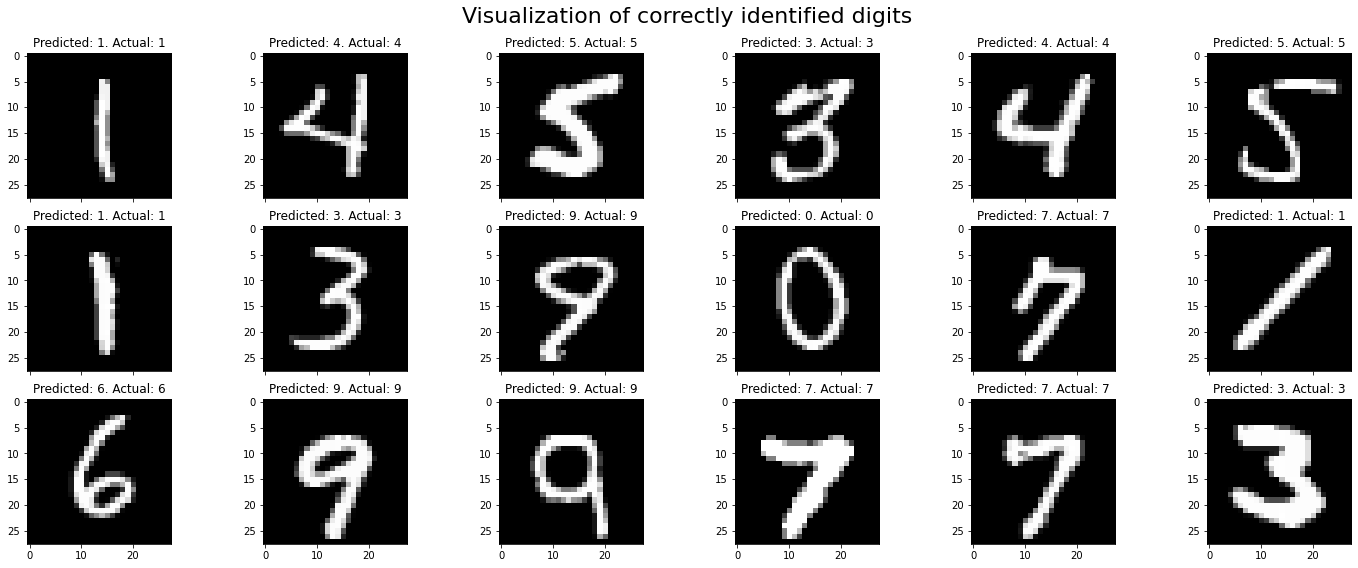

In [519]:
plot_digits(y_test, predicted, plot_correct_digits=True)

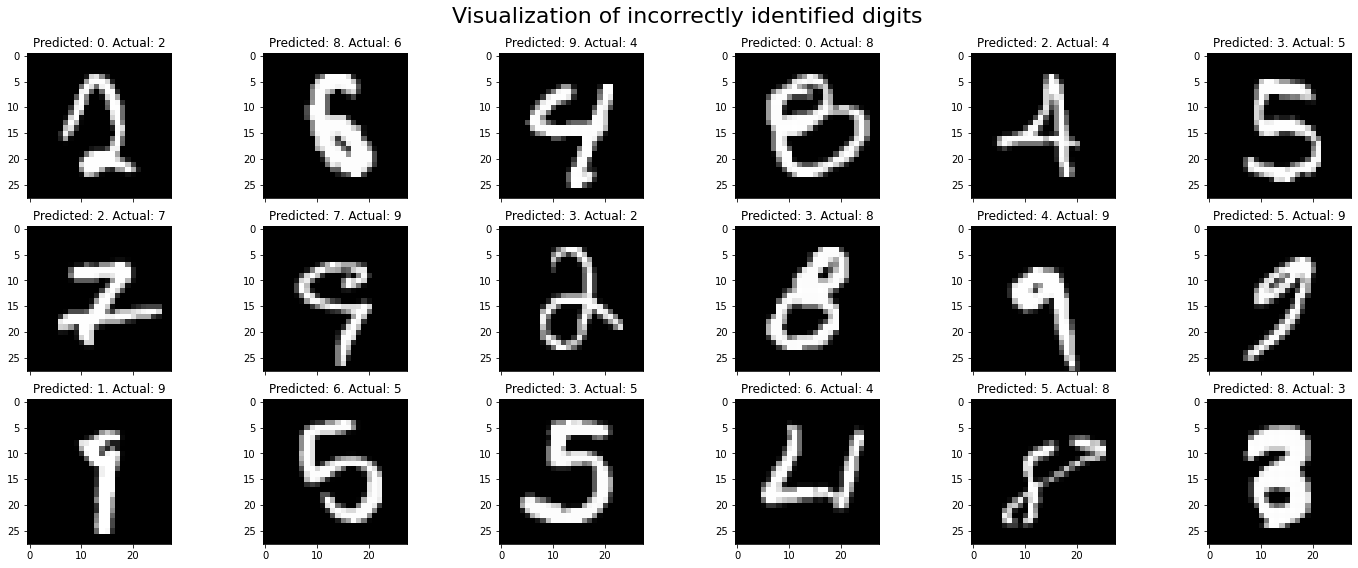

In [520]:
plot_digits(y_test, predicted, plot_correct_digits=False)

It can be seen that the digits that were plotted with the linear model are rather rudimentary and have a clear structure. However, the linear model is unable to plot certain incorrect digits that slightly diverge from the normal way of writing the number.

## 3.2. Tuning the linear kernel

In [521]:
def get_best_params(kernel, x_train, y_train, params_grid, to_csv=True, to_display=False, return_train_score=True):
    """
    Run a Grid search through the training data to get the best parameters
    """
    #Create a dictionary of possible parameters

    #Create the GridSearchCV object
    grid_clf = GridSearchCV(svm.SVC(kernel=kernel), params_grid, verbose=1, n_jobs=6, return_train_score=return_train_score)
    
    #Fit the data with the best possible parameters
    grid_clf = grid_clf.fit(x_train, y_train)

    results_output = pd.DataFrame(grid_clf.cv_results_)
    
    if to_csv:
        results_output.to_csv(f"SVM_{kernel}.csv")
        
    if to_display:
        display(results_output.head())

    print("Best parameters: ", grid_clf.best_params_)
    return results_output

In [522]:
# Set params and get results
params_grid_linear = {'C': [0.001, 0.01, 0.1, 1, 10, 50, 100], 
                      'gamma': [0.0001, 0.001, 0.01, 0.1]}

results_output = get_best_params('linear', x_train, y_train, params_grid = params_grid_linear)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 140 out of 140 | elapsed: 19.2min finished


Best parameters:  {'C': 0.1, 'gamma': 0.0001}


In [559]:
def plot_SVM_accuracy(df, params = ['param_C', 'param_gamma'], title = 'linear'):
    """
    Create a plot for the accuracy of train, test data, 
    as well as their differences
    """
    params_to_use = ['mean_test_score', 'mean_train_score'] + params
    df = df[params_to_use].copy()
    df = df.astype(float)
    
    # Create pivot tables for the plots
    p1 = df.pivot_table(index=params[0], columns = params[1], values = 'mean_train_score')
    p2 = df.pivot_table(index=params[0], columns = params[1], values = 'mean_test_score')
    diff = p1-p2
    
    # Create the plot
    fig, axs = plt.subplots(1,3,figsize=(15,7))

    fig.suptitle(f"Accuracy of train, test data for the {title} SVM model", fontsize = 18)

    sns.heatmap(p1, ax=axs[0], vmin=0, vmax = 1, linewidth = 1, linecolor = 'white', cmap=cmap, annot=True)
    axs[0].set_title("Accuracy of train data")
    sns.heatmap(p2, ax=axs[1], vmin=0, vmax=1, linewidth=1, linecolor = 'white', cmap=cmap, annot=True)
    axs[1].set_title("Accuracy of test data")
    sns.heatmap(diff, ax=axs[2],linewidth=1, linecolor = 'white', cmap=cmap, annot=True)
    axs[2].set_title("Differences in accuracies")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    fig.savefig(f'{title}_svm.png')

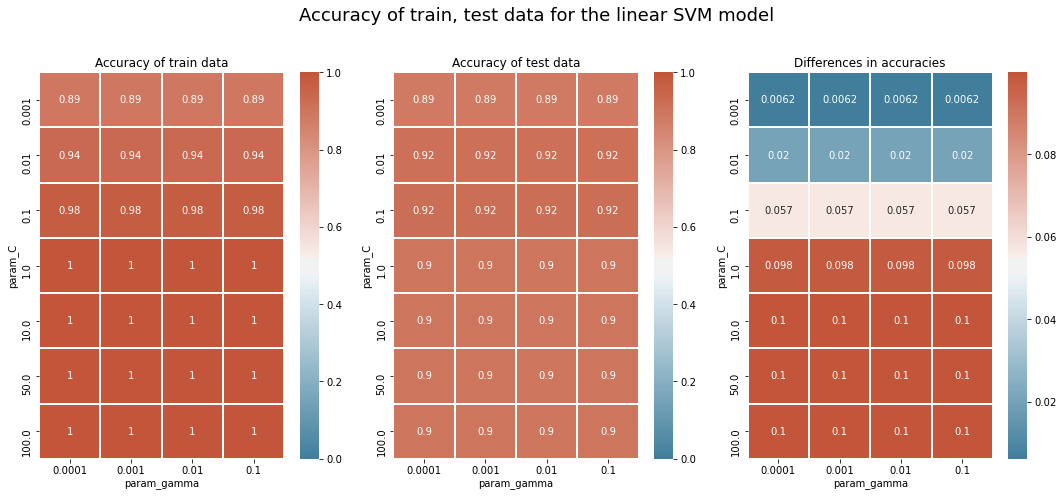

In [524]:
plot_SVM_accuracy(results_output)

## 3.3. Radial Basis Function Kernel

In [526]:
# Set params and get results
params_grid_rbf = {'C': [0.001, 0.01, 0.1, 1, 10, 50, 100], 
                      'gamma': [0.0001, 0.001, 0.01, 0.1]}

results_output_rbf = get_best_params('rbf', x_train, y_train, params_grid = params_grid_rbf)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 140 out of 140 | elapsed: 52.2min finished


Best parameters:  {'C': 10, 'gamma': 0.01}


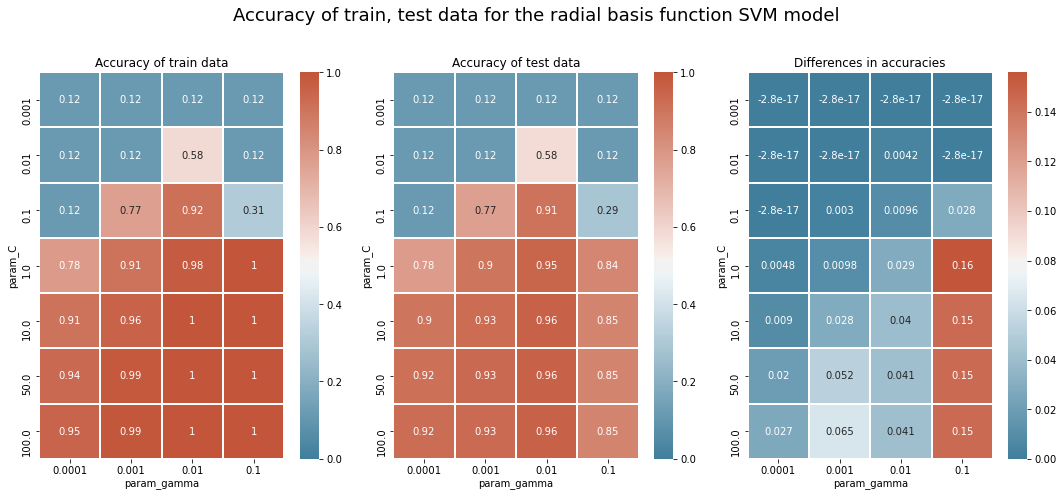

In [560]:
plot_SVM_accuracy(results_output_rbf, title = 'radial basis function')

## 3.4. Polynomial kernel

In [530]:
# Set params and get results
params_grid_poly = {'gamma': [0.0001, 0.001, 0.01, 0.1],
                      'degree': [2,4,6],
                      'coef0': [1, 5, 10, 20]}

results_output_poly = get_best_params('poly', x_train, y_train, params_grid = params_grid_poly)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 240 out of 240 | elapsed: 20.1min finished


Best parameters:  {'coef0': 1, 'degree': 2, 'gamma': 0.1}


In [549]:
def plot_SVM_poly_accuracy(df, params = ['param_coef0', 'param_gamma']):
    """
    Plot SVM distribution of accuracy. Divided into the degree,
    coefficient parameter, and gamma parameter.
    """
    
    match_dict = {0:2,
                  1:4,
                  2: 6}

    fig, axs = plt.subplots(3,3,figsize=(17,16))

    fig.suptitle("Accuracy of polynomial SVM data by coefficient, gamma, and degree", fontsize = 18)
    for i,k in match_dict.items():
        d2 = df[df['param_degree'] == k].copy()

        p1 = d2.pivot_table(index=params[0], columns = params[1], values = 'mean_train_score')
        p2 = d2.pivot_table(index=params[0], columns = params[1], values = 'mean_test_score')
        diff = p1-p2
        
        sns.heatmap(p1, ax=axs[i,0], vmin=0, vmax = 1, linewidth = 1, linecolor = 'white', cmap=cmap, annot=True)
        axs[i,0].set_title(f"Degree {k}: Accuracy of train data")
        sns.heatmap(p2, ax=axs[i,1], vmin=0, vmax=1, linewidth=1, linecolor = 'white', cmap=cmap, annot=True)
        axs[i,1].set_title(f"Degree {k}: Accuracy of test data")
        sns.heatmap(diff, ax=axs[i,2],linewidth=1, linecolor = 'white', cmap=cmap, annot=True, vmin = 0, vmax = 0.3)
        axs[i,2].set_title(f"Degree {k}: Differences in accuracies")
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('poly_svm.png')

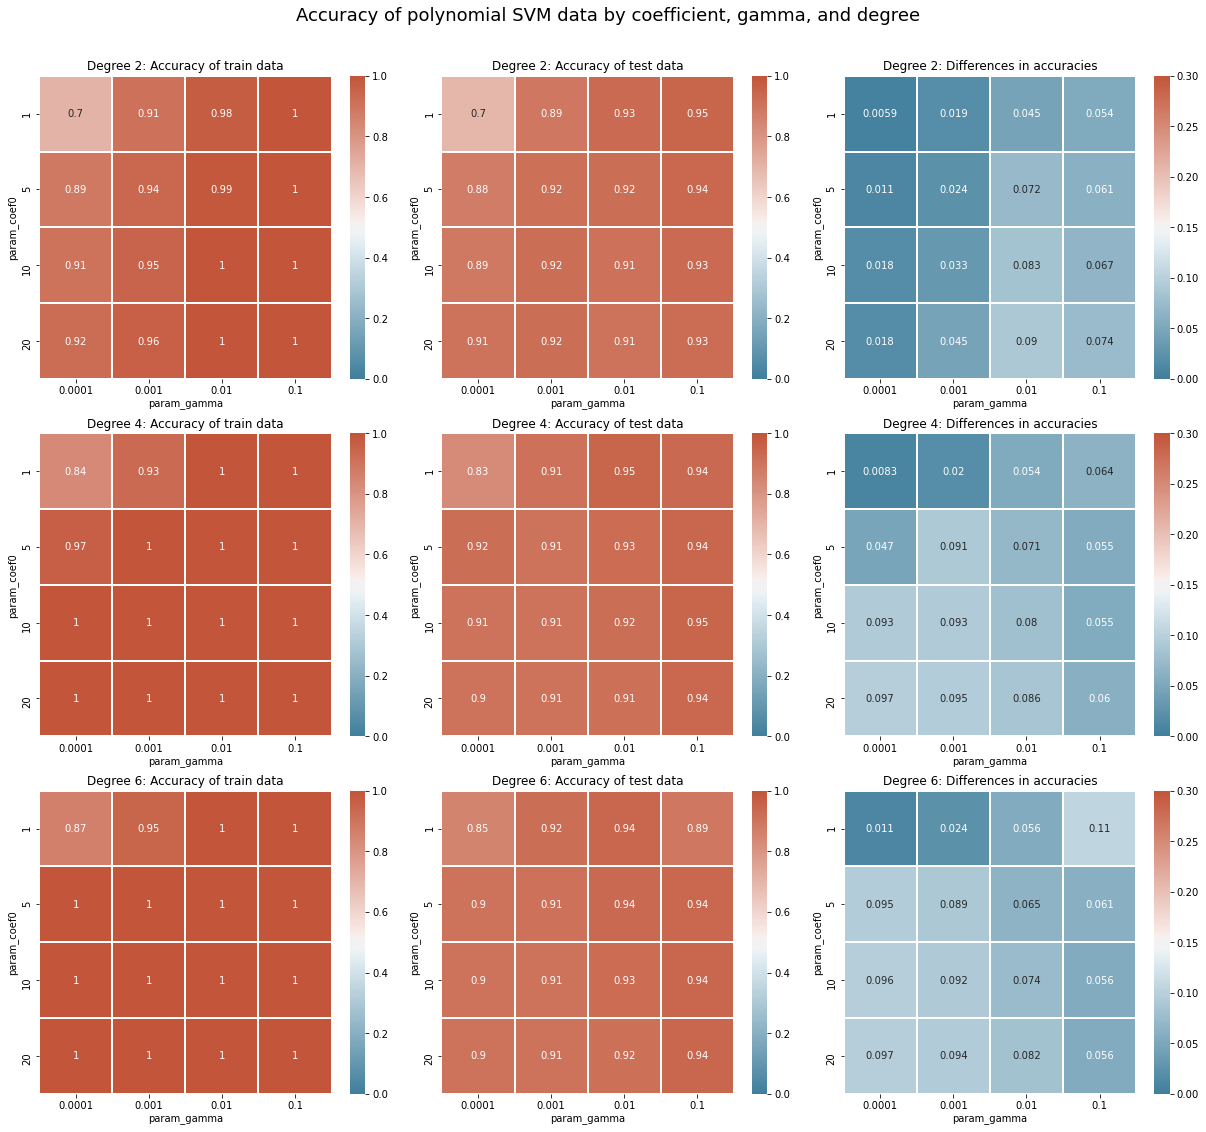

In [550]:
plot_SVM_poly_accuracy(results_output_poly)

## 3.5. Sigmoid

Only C and gamma are visualized for the sigmoid.

In [533]:
# Set params and get results
params_grid_sigmoid = {'C': [0.001, 0.01, 0.1, 1, 10, 50, 100],
                     'gamma': [0.0001, 0.001, 0.01, 0.1]}

results_output_sigmoid = get_best_params('sigmoid', x_train, y_train, params_grid = params_grid_sigmoid)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 140 out of 140 | elapsed: 26.6min finished


Best parameters:  {'C': 50, 'gamma': 0.001}


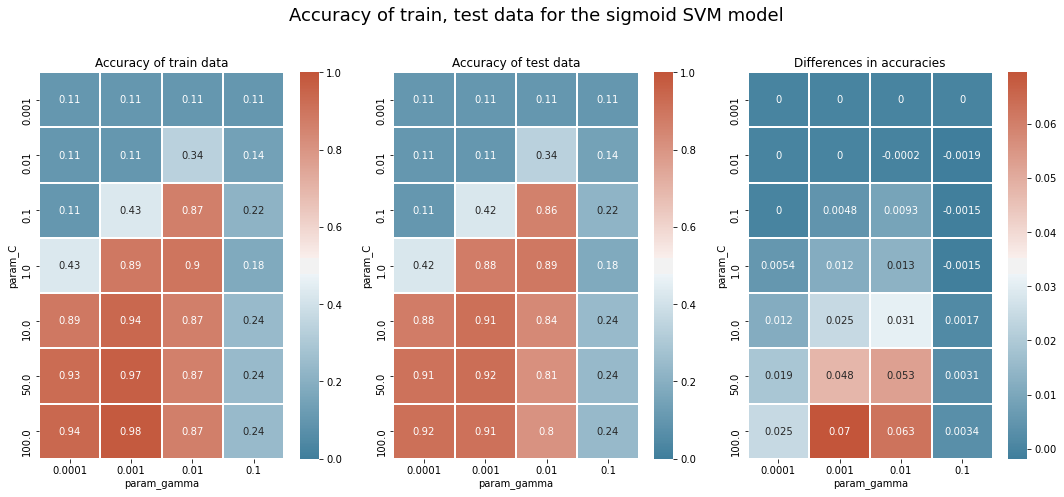

In [534]:
plot_SVM_accuracy(results_output_sigmoid, title = 'sigmoid')

# 4. Neural Networks - Implement from Scratch

In [567]:
class NeuralNetwork:
    """
    Adapted from multiple online solutions that did not have 101 hidden layers
    
    Neural Network class for 101 hidden layers. Weights
    are initialized randomly, gradient descent is used
    for rule updating
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        # Initialize weights
        self.weights_1 = np.random.randn(101, len(x.T) + 1) # one more for the bias term
        self.weights_2 = np.random.randn(10, 101)
    
    def bias_add(self, x):
        """
        Add bias to input data
        """        
        i = np.ones((len(x), len(x.T) + 1), dtype=np.float64)
        i[:, :-1] = x
        return i
        
    def target(self, y):
        """
        Conversion of multi-class labels to dummy variables
        """        
        return np.array([np.float_(y == i) for i in range(len(set(y)))], dtype=np.float64).T
    
    def predict(self, x):
        """
        Perform the forward propagation
        """
        z1 = np.float_(np.matmul(self.bias_add(x), self.weights_1.T))
        alpha1 = 1 / (1 + np.exp(-z1))
        z2 = np.matmul(alpha1, self.weights_2.T)
        alpha2 = 1 / (1 + np.exp(-z2))

        # Perform a softmax operation so that the sum would be equal to one
        alp_sum = np.sum(alpha2, axis=1, dtype=np.float64)[:, np.newaxis]
        alpha2 = alpha2 / alp_sum

        return alpha1, alpha2

    def cost(self, x, y):
        """
        Calculate the cost of the neural network
        """        
        return np.sum((self.predict(x)[1] - self.target(y)) ** 2)/(2 * len(x))

    def gradient(self, x, y):
        """
        Returns a tuple of the gradient of the weights from the input layer to the hideen layer,
        as well as the weights from the hidden layer to the output layer using backprop
        """
        alpha1, alpha2 = self.predict(x)
        x1 = np.ones((x.shape[0], x.shape[1] + 1))
        x1[:, :-1] = x

        w2_delta = np.dot(alpha1.T, (y - alpha2) * alpha2 * (1 - alpha2)) / len(x)
        w1_delta = np.dot(x1.T, (np.dot((y - alpha2) * alpha2 * (1 - alpha2), self.weights_2) * alpha1 * (1 - alpha1))) / len(x)
        return w1_delta.T, w2_delta.T
    
    def grad_descent(self, l=0.001, steps=10):
        """
        Perform gradient descent on the data
        """
        for step in range(steps):
            w1_delta, w2_delta = self.gradient(self.x, self.target(self.y))
            self.weights_1 += l * w1_delta
            self.weights_2 += l * w2_delta
            
            # To check progress
            if (step + 1) % 100 == 0:
                print(f"{step + 1} steps completed")
    
    def stoc_grad_descent(self, epochs=3, l=0.001, steps_per_epoch=None):
        """
        Perform stochastic gradient descent (for faster convergence)
        """

        # Shuffle the data
        
        z = np.zeros((len(self.x), 785))
        z[:,:-1] = self.x
        z[:, -1] = self.y
        np.random.shuffle(z)
        x, y = z[:, :-1], z[:, -1]
        if steps_per_epoch == None: rang = len(x)
        else: rang = steps_per_epoch
            
        for epoch in range(epochs):
            print(f"epoch {epoch + 1}")
            for i in range(0, rang):
                
                w1_delta, w2_delta = self.gradient(x=x[i,:][np.newaxis], y=self.target(y)[i, :])
                self.weights_1 += l * w1_delta
                self.weights_2 += l * w2_delta

In [569]:
model = NeuralNetwork(x_train, y_train)

In [570]:
cost = model.cost(model.x, model.y)

In [571]:
steps = [i for i in range(50)]
step_cost = [cost]
for i in steps:
    model.grad_descent(l=1, steps=20)
    cost_t = model.cost(model.x, model.y)
    step_cost.append(cost_t)
    print(f"Cost = {cost_t}")

Cost = 0.6183019448919408
Cost = 0.5923410352774341
Cost = 0.5591931063066355
Cost = 0.5249508409809086
Cost = 0.4931637985043696
Cost = 0.46501183971521703
Cost = 0.4391709224583843
Cost = 0.4153944273033024
Cost = 0.3935921804428769
Cost = 0.37517665925541066
Cost = 0.3590337849728835
Cost = 0.3444440276371533
Cost = 0.3313496855011681
Cost = 0.3192166709874518
Cost = 0.3078152305281616
Cost = 0.2971065303529605
Cost = 0.28699934573612257
Cost = 0.27741674815402156
Cost = 0.26833959731780294
Cost = 0.2597752746681858
Cost = 0.25172369942424866
Cost = 0.24417205813426984
Cost = 0.23709368952618562
Cost = 0.23045255454486754
Cost = 0.22421503453428296
Cost = 0.2183542020130848
Cost = 0.21284688715613143
Cost = 0.20766936006325595
Cost = 0.20279581805439328
Cost = 0.1982002658687555
Cost = 0.19385917501416464
Cost = 0.189752751151662
Cost = 0.1858645383561519
Cost = 0.18218009805226437
Cost = 0.1786857189341697
Cost = 0.17536768578227396
Cost = 0.17221223330682114
Cost = 0.1692061617117

In [583]:
# Predict labels
predicted = model.predict(x_test)[1]
predicted = predicted.argmax(axis=1)

# Calculate accuracy
metrics.accuracy_score(y_test, predicted)

0.7782

In [584]:
def plot_conf_matrix(predicted, y_test):
    """
    Plots a confusion matrix based on the predicted and 
    actual y values
    """
    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    fig, ax = plt.subplots(figsize=(12,7))
    sns.heatmap(confusion_matrix(predicted, y_test), annot = True, fmt = 'g', cmap=cmap)
    ax.set_xlabel("Actual digits")
    ax.set_ylabel("Predicted digits")
    ax.set_title("Confusion matrix for the Neural Network")

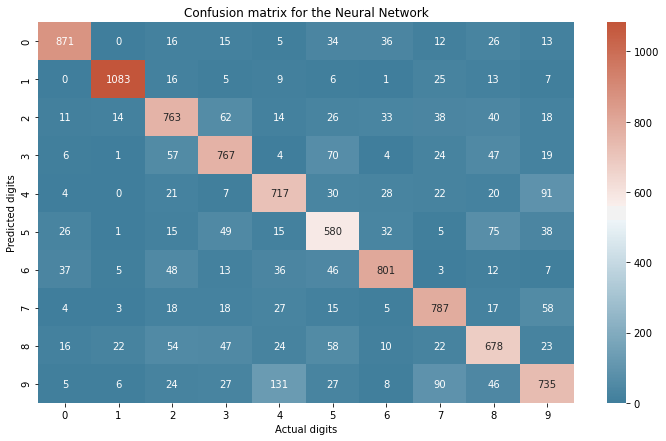

In [585]:
plot_conf_matrix(predicted, y_test)

It is noticeable that substantial amount of fours were classified as 9s.

# 5. Neural Network practice

In [473]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

In [474]:
model = tf.keras.models.Sequential()

In [475]:
# Input layer
model.add(tf.keras.layers.Flatten())

# Hidden layer - two hidden layers
model.add(tf.keras.layers.Dense(1200, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1200, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.5))

# Output layer
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

# Define parameters
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

In [476]:
history = model.fit(x_train, y_train, epochs=25,
         batch_size=128,
         verbose=1,
         shuffle=True)

Epoch 1/25
469/469 [==============================] - 12s 25ms/step - loss: 0.2884 - accuracy: 0.9135
Epoch 2/25
469/469 [==============================] - 13s 27ms/step - loss: 0.1310 - accuracy: 0.9598
Epoch 3/25
469/469 [==============================] - 12s 26ms/step - loss: 0.0985 - accuracy: 0.9696
Epoch 4/25
469/469 [==============================] - 12s 26ms/step - loss: 0.0850 - accuracy: 0.9732
Epoch 5/25
469/469 [==============================] - 13s 28ms/step - loss: 0.0699 - accuracy: 0.9776
Epoch 6/25
469/469 [==============================] - 12s 25ms/step - loss: 0.0624 - accuracy: 0.9794
Epoch 7/25
469/469 [==============================] - 12s 25ms/step - loss: 0.0569 - accuracy: 0.9816
Epoch 8/25
469/469 [==============================] - 12s 25ms/step - loss: 0.0533 - accuracy: 0.9828
Epoch 9/25
469/469 [==============================] - 12s 25ms/step - loss: 0.0487 - accuracy: 0.9844
Epoch 10/25
469/469 [==============================] - 13s 27ms/step - loss: 0.046

In [477]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss, val_acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.0842 - accuracy: 0.9826
0.08423490077257156 0.9825999736785889
